**Named Entity Recognition**
Рассмотрим набор данных, определим необходимые вспомогательные классы для работы с датасетом. Предсказывать будем индивидуальный тег у каждого слова. 
Список тегов задаётся следующим образом:

    geo = Geographical Entity
    org = Organization
    per = Person
    gpe = Geopolitical Entity
    tim = Time indicator
    art = Artifact
    eve = Event
    nat = Natural Phenomenon
Если слово нельзя соотнести ни с одним из вышеперечисленных тегов, ставится zero-tag (O). Далее приводится список POS-тегов по их расшифровке. Именно такие POS-теги содержит в себе данный датасет.

    1.	CC	Coordinating conjunction
	2.	CD	Cardinal number
	3.	DT	Determiner
	4.	EX	Existential there
	5.	FW	Foreign word
	6.	IN	Preposition or subordinating conjunction
	7.	JJ	Adjective
	8.	JJR	Adjective, comparative
	9.	JJS	Adjective, superlative
	10.	LS	List item marker
	11.	MD	Modal
	12.	NN	Noun, singular or mass
	13.	NNS	Noun, plural
	14.	NNP	Proper noun, singular
	15.	NNPS Proper noun, plural
	16.	PDT	Predeterminer
	17.	POS	Possessive ending
	18.	PRP	Personal pronoun
	19.	PRP$ Possessive pronoun
	20.	RB	Adverb
	21.	RBR	Adverb, comparative
	22.	RBS	Adverb, superlative
	23.	RP	Particle
	24.	SYM	Symbol
	25.	TO	to
	26.	UH	Interjection
	27.	VB	Verb, base form
	28.	VBD	Verb, past tense
	29.	VBG	Verb, gerund or present participle
	30.	VBN	Verb, past participle
	31.	VBP	Verb, non-3rd person singular present
	32.	VBZ	Verb, 3rd person singular present
	33.	WDT	Wh-determiner
	34.	WP	Wh-pronoun
	35.	WP$	Possessive wh-pronoun
	36.	WRB	Wh-adverb

In [10]:
import numpy as np
import pandas as pd
import logging
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

class Entities:

  """
  Convert the words/tags to the list of indices that correspond to the individual word.
  """
  class Auxiliary:
    @staticmethod
    def get_w2i_indices(words: list) -> dict:
      word2index = {w: i for i, w in enumerate(words)}
      return word2index

    @staticmethod
    def get_t2i_indices(tags: list) -> dict:
      tag2index = {t: i for i, t in enumerate(tags)}
      return tag2index

  """
  A wrapper to read the data.
  """

  class DataReader(object):
    def __init__(self, name):
        self.name = name

    def read_data(self):
        csv = pd.read_csv(self.name, encoding="latin1")
        return csv
  """
  A wrapper to store the data and conveniently extract the sentences, one-by-one, along with its POS/tags.
  """

  class BasicSentenceProducer(object):
    def __init__(self, data):
      self.counter = 1
      self.data = data
      self.empty = False

    def get_next_sentence(self):
      try:
        key = self.data["Sentence #"] == f"Sentence: {self.counter}"
        sentence = self.data[key]
        self.counter += 1
        words = sentence["Word"].values.tolist()
        pos = sentence["POS"].values.tolist()
        tags = sentence["Tag"].values.tolist()
        return words, pos, tags
      except ValueError:
        logging.log(
            f"ValueError encountered, self.counter == {self.counter} (wrong key passed or the end of data was reached)"
        )
        self.empty = True
        return None, None, None

    def reset(self):
      self.counter = 1

  class Aggregator:
    def __init__(self, data):
      self.counter = 1
      self.data = data
      self.aggregated = self.data.groupby("Sentence #").apply(self.__aggregate)
      self.sentences = [sentence for sentence in self.aggregated]
      self.unique_tags = list(set(data["Tag"].values.tolist()))
      self.unique_words = self.get_unique_words_with_padding(padding = True)

    def __aggregate(self, data):
      words = data["Word"].values.tolist()
      pos = data["POS"].values.tolist()
      tags = data["Tag"].values.tolist()
      zipper = zip(words, pos, tags)
      aggregated = [(w, p, t) for w, p, t in zipper]
      return aggregated
    
    # [retarded] Either use a generator, or remember the word depending on the constructor parameters.
    def get_unique_words_with_padding(self, padding = True):
      words = list(set(self.data["Word"].values))
      if padding:
        words.append("ENDPAD")
      return words

  class MemoryTagger(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
      vocabulary = {}
      self.tags = []
      for word, tag in zip(X, y):
        if tag not in self.tags:
          self.tags.append(tag)
        if word in vocabulary:
          if tag in vocabulary[word]:
            vocabulary[word][tag] += 1
          else:
            vocabulary[word][tag] = 1
        else:
          vocabulary[word] = {tag: 1}
      self.memory = {}
      for k, d in vocabulary.items():
        self.memory[k] = max(d, key=d.get)
    def predict(self, X, y=None):
      return [self.memory.get(x, 'O') for x in X]


Попробуем взглянуть на имеющиеся данные. Посмотрим, сколько у нас уникальных тегов, общее количество предложений и слов, плюс небольшой взгляд на саму структуру датасета. 
Сам датасет состоит из слов, каждое предложение обозначено своим идентификатором в столбце, также содержит POS-теги и те теги, которые нужно определить с помощью моделей.
Следует отметить, что большинству слов в датасете назначен zero-tag, данные предварительно можно "очистить". 

**London:** B-geo (географическое местоположение)

**Iraq:** B-geo (географическое местоположение)

**British:** B-gpe (геополитическая принадлежность, напр. народ/этнос)

Как видно ниже, датасет состоит из ~48k предложений и ~35k слов. Следовательно, слова повторяются и возможно, что у одинакового слова в зависимости от контекста изменяется тег.

In [11]:
dataset = Entities.DataReader("ner_dataset.csv").read_data()
dataset = dataset.fillna(method = "ffill")
print(dataset.loc[dataset['Sentence #'] == "Sentence: 1"])

     Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O
15  Sentence: 1            the   DT      O
16  Sentence: 1     withdrawal   NN      O
17  Sentence: 1             of   IN      O
18  Sentence: 1        British   JJ  B-gpe
19  Sentence: 1         troops  NNS      O
20  Sentence: 1           from   IN      O
21  Sentence: 1           that   DT      O
22  Sentenc

In [12]:
words = list(set(dataset["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print(f"Words: {n_words}")
dataset.tail(10)

Words: 35179


,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


Рассмотрим базовую модель (baseline) без использования нейронных сетей, на основе хэш-таблицы. Пробуем запомнить самую распространенную именованную сущность для каждого слова. Если слово не попало в словарь, возвращаем zero-tag.
Благодаря интерфейсу из Entities.BasicSentenceProducer, мы можем удобно по запросу получать списки слов и тегов, взаимнооднозначно соответствующих друг другу. Сначала, испробуем данную модель на одном предложении.

In [13]:
producer = Entities.BasicSentenceProducer(dataset)
tagger = Entities.MemoryTagger()
sentence, pos, tags = producer.get_next_sentence()
tagger.fit(sentence, tags)

predictions = np.asarray(tagger.predict(sentence))
indices = np.where(predictions != 'O')[0]

print(f"Predictions: {predictions}")
for index in indices:
  print(f"Word: {sentence[index]}, Tag: {predictions[index]}")
  

Predictions: ['O' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'B-geo' 'O' 'O' 'O'
 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O' 'O']
Word: London, Tag: B-geo
Word: Iraq, Tag: B-geo
Word: British, Tag: B-gpe


Модель отрабатывает на одном предложении, из-за своей простоты, неповторяющихся/неконфликтующих тегов. Теперь, возьмем все возможные Words/Tags, применим модель вместе с 5-Fold кросс-валидацией, построим отчёт со значениями Precision/Recall/F1.
Несмотря на казалось бы хорошее значение F1, данные результаты оставляют желать лучшего из-за несбалансированности датасета. Значительное большинство слов не содержит в себе полезного тега. У многих тегов крайне низкий Recall-score, невозможно определить True Positives для слов, которые мы заранее не знаем.

In [14]:

all_words = dataset["Word"].values.tolist()
all_tags = dataset["Tag"].values.tolist()
predictions = cross_val_predict(estimator = Entities.MemoryTagger(), X = all_words, y = all_tags, cv = 5)
report = classification_report(y_pred = predictions, y_true = all_tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.20      0.05      0.09       402
       B-eve       0.54      0.25      0.34       308
       B-geo       0.78      0.85      0.81     37644
       B-gpe       0.94      0.93      0.94     15870
       B-nat       0.42      0.28      0.33       201
       B-org       0.67      0.49      0.56     20143
       B-per       0.78      0.65      0.71     16990
       B-tim       0.87      0.77      0.82     20333
       I-art       0.04      0.01      0.01       297
       I-eve       0.39      0.12      0.18       253
       I-geo       0.73      0.58      0.65      7414
       I-gpe       0.62      0.45      0.52       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.69      0.53      0.60     16784
       I-per       0.73      0.65      0.69     17251
       I-tim       0.58      0.13      0.21      6528
           O       0.97      0.99      0.98    887908

    accuracy              

Построим гистограмму распределения длины предложений в датасете. Это необходимо, чтобы дополнить предложения паддингом, все входные данные должны иметь общую размерность (из-за интерфейса TF). Сначала, нужно получить хэш-таблицы слов, тегов и их индексов.

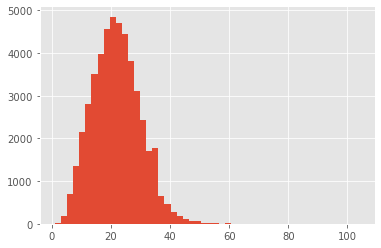

In [15]:
PLOT_BINS = 50
MAXLEN = 50
aggregator = Entities.Aggregator(dataset)
plt.style.use("ggplot")
plt.hist([len(s) for s in aggregator.sentences], bins = PLOT_BINS)
plt.show()

В качестве возможных улучшений рассматривается нейросетевой подход с Bidirectional-LSTM, размерности эмбеддингов фиксированные (50) + выходной слой с функцией активации Softmax.
Нужно "отобразить" предложения с его сопутствующим вектором чисел, добавить padding для того, чтобы входные вектора имели одинаковый размер.
Предсказываемые данные преобразуем в тензор 0/1, индексу единицы соотвествует конкретный тип тега.   

In [16]:
tags = aggregator.unique_tags
words = aggregator.unique_words
tag2index = Entities.Auxiliary.get_t2i_indices(tags)
word2index = Entities.Auxiliary.get_w2i_indices(words)

X = [[word2index[word[0]] for word in sentence] for sentence in aggregator.sentences]
X = pad_sequences(maxlen = MAXLEN, sequences = X, padding = "post", value = n_words - 1)

y = [[tag2index[word[2]] for word in sentence] for sentence in aggregator.sentences]
y = pad_sequences(maxlen = MAXLEN, sequences = y, padding = "post", value = tag2index["O"])
y = [to_categorical(i, num_classes = len(tags)) for i in y]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.1)

In [17]:
input = Input(shape=(MAXLEN,))
model = Embedding(input_dim    = n_words, 
                  output_dim   = 50, 
                  input_length = MAXLEN)(input)
model = Dropout(0.1)(model)
model = Bidirectional(
          LSTM(
            units = 100, 
            return_sequences = True,
            recurrent_dropout = 0.1
          )
        )(model)
out = TimeDistributed(
        Dense(
          len(tags), 
          activation = "softmax"
        )
      )(model)
model = Model(input, out)
model.compile(optimizer = "rmsprop",
              loss      = "categorical_crossentropy", 
              metrics   = ["accuracy"])
history = model.fit(X_train, 
                    np.array(Y_train), 
                    batch_size       = 32,
                    epochs           = 5,
                    validation_split = 0.1, 
                    verbose          = 1
                   )

Epoch 1/5
1214/1214 [==============================] - 193s 158ms/step - loss: 0.1376 - accuracy: 0.9651 - val_loss: 0.0633 - val_accuracy: 0.9811
Epoch 2/5
1214/1214 [==============================] - 190s 157ms/step - loss: 0.0542 - accuracy: 0.9843 - val_loss: 0.0520 - val_accuracy: 0.9847
Epoch 3/5
1214/1214 [==============================] - 192s 158ms/step - loss: 0.0454 - accuracy: 0.9866 - val_loss: 0.0479 - val_accuracy: 0.9858
Epoch 4/5
1214/1214 [==============================] - 192s 158ms/step - loss: 0.0410 - accuracy: 0.9879 - val_loss: 0.0461 - val_accuracy: 0.9864
Epoch 5/5
1214/1214 [==============================] - 187s 154ms/step - loss: 0.0381 - accuracy: 0.9887 - val_loss: 0.0467 - val_accuracy: 0.9860


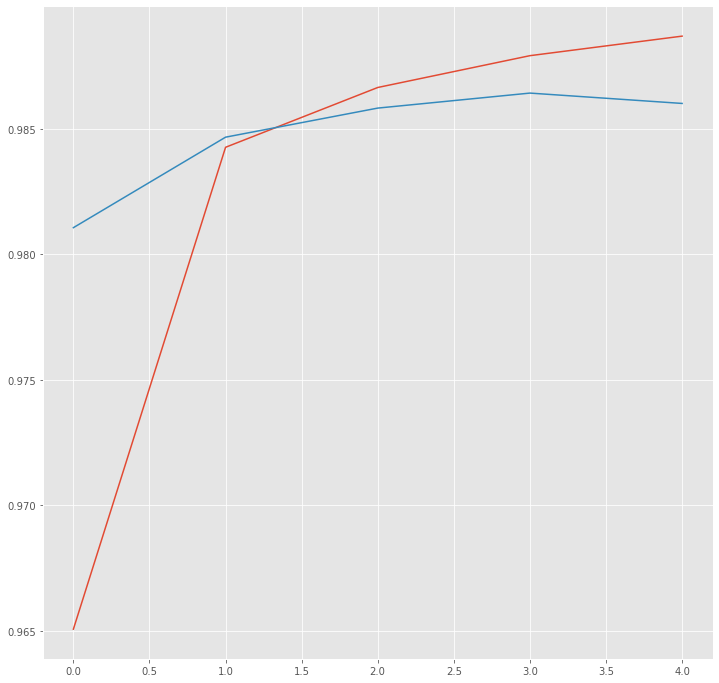

In [18]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12, 12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

После пяти эпох, полученная точность val_accuracy (при небольшой тестовой выборке) достигает 0.986. Вполне вероятно, что модель переобучилась. Попробуем проверить результат на конкретном предложении.
Интересно, но в предложении содержится опечатка, тем не менее, тег распознался корректно.

In [24]:
index = 100
predictions = model.predict(np.array([X_test[index]]))
predictions = np.argmax(predictions, axis = -1)
for word, prediction in zip(X_test[index], predictions[0]):
    print(f"{words[word]}: {tags[prediction]}")

Results: O
from: O
the: O
Niger: B-gpe
's: O
parliamentary: O
elections: O
,: O
also: O
held: O
Sarturday: B-per
,: O
have: O
not: O
been: O
announced: O
.: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O
ENDPAD: O


**Выводы**
1. При задаче классификации, необходимо проверять и иные параметры, помимо Accuracy. Так, в baseline-dict-модели, несмотря на хороший F1-score, значительно страдает Recall. Следовательно, данная модель не подходит. 
2. Bi-LSTM оказалась рабочим вариантом для данного датасета. Неясно, как будет вести себя модель, если попробовать предсказать предложение, которое содержит слова, не встречающиеся в датасете. Вариант с CRF не рассматривался.
3. Для работы с датасетами лучше писать свои универсальные обёртки :)